In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

from mrlattice.lattice.configure import LatticeArrayScheme
from mrlattice.lattice.generate import LatticeArray
from mrlattice.plotting import generate_print_lattice as gpl

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.2.0"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>
<class '__main__.SuperimposeLatticeArrayPlotWidget'>


In [4]:
%load_ext jupyter_spaces

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (12, 12)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Summary

We compare the fixed number (Ipp) and fixed width (Kayran) schemes with emphasis on the number of cells per region. We conclude that the Kayran scheme allows for a high number of cells next to the kernel regions while simultaneously providing a fast reduction of the number for coarser regions.


# Profile Plots 

In this notebook we want to compare the two lattice schemes that are implemented in the `LatticeArray` types. The scheme of a lattice dictates the rules for building coarsening regions. Given a choice for the number of coarse to fine borders the coarsening regions make up the transition region connecting the kernel (region with finest resolution) and buffer (region with coarsest resolution).  
The two schemes are:
- Fixed number (Ipp) scheme:  
   The number of cells per coarsening region will be fixed, regardless of their resolution. 

- Fixed width (Kayran) scheme:  
   The (physical) spatial width of the coarsening regions will be fixed. For each coarsening regions the number of cells will be such that at least this width will be filled.

## Sample Lattices

We will use three example lattices for our analysis. As the coarsening regions are identical for all time slices, we choose the smallest `repeat` number and consider only the first time slice in the following. The settings for the `finest_width` and `buffer` are arbitrary, but chosen in a way to give pleasent plots later on. Setting the number of borders to 6 generates wide enough coarsening regions without blowing out the scale.  
The first lattice (fw) employs the Kayran scheme, the other two the Ipp scheme with different settings. The latter are chosen so that the second lattice (fn_narrow) has the same number of cells for the coarsest region (not buffer) as the fw lattice, namely 2. 2 is also the minimal number we allow for any region. The third lattice (fn_wide) has the same number of cells for the finest region (not kernel) as the fw lattice, namely 32. This leaves the regions' width for the fw lattice to be 64, which is also the smallest possible value for 6 regions. The number of 32 for the first region is because we fill a width of 64 with cells of resolution 2. For the last region we demand at least 2 cells, which therfore must be of resolution 32 fo fit. These configurations are well suited to compare the different schemes.

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

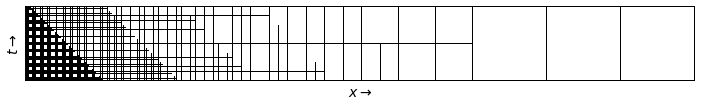

In [6]:
fw_lattice = LatticeArray(
        scheme=LatticeArrayScheme.FIXED_WIDTH_SCHEME,
        coarse_steps=6,
        borders_width=64,
        buffer=3,
        finest_width=5,
        repeat=1,
    )
LatticeArrayPlotWidget(lattice=fw_lattice)

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

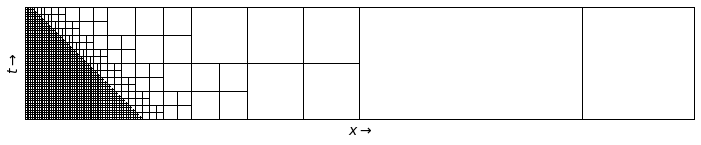

In [7]:
fn_lattice_narrow = LatticeArray(
        scheme=LatticeArrayScheme.FIXED_NUMBER_SCHEME,
        coarse_steps=6,
        borders_width=2,
        buffer=3,
        finest_width=5,
        repeat=1,
    )
LatticeArrayPlotWidget(lattice=fn_lattice_narrow)

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

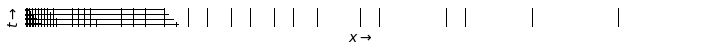

In [8]:
fn_lattice_wide = LatticeArray(
        scheme=LatticeArrayScheme.FIXED_NUMBER_SCHEME,
        coarse_steps=6,
        borders_width=32,
        buffer=3,
        finest_width=5,
        repeat=1,
    )
LatticeArrayPlotWidget(lattice=fn_lattice_wide)

## Profile Plots

In the following we will discuss 3 plots. The first one shows the resolution of the cells plotted over the physical (spatial) coordinate x. The unit annotation of "finest width" means, that we always use the resolution of the kernel as unit 1, so that a resolution of 32 signifies that this cell is 32 times one cell of the kernel. The second plot is a histogram of the numbers of cells per resolution and its cumulative distribution is shown in the third graph. Note that the x-scales of these histograms are $\log_2$. The power law connection between the resolutions $2^i$ obviously arises from the fact that we double the resolution for each next region.  
The three lattices are color coded. The fw lattice is always blue, the fn_narrow lattice is orange and the fn_wide lattice is green. Their defining values for their schemes are included in the legend.  
As noted previously, we are only interested in the coarsening regions. For the plots we therefore cut away any data that stems from the buffer and introduce the gray hatched region for the kernel. The width or height of this hatched region don't represent any values of the kernel region and are chosen for visually pleasing results.  
Also note that any of the following deductions are only valid for the plotted regions and lattice configurations. Extrapolating the tendencies to more borders would be possible for the Ipp scheme, but is certainly wrong for the Kayran scheme. This is because when adding borders to Kayran scheme lattices, one also has to increase the width of the borders regions so that at least two cells of the new coarsest region fit into the chosen width. So extrapolation requires a change of the confguration for the Kayran scheme.

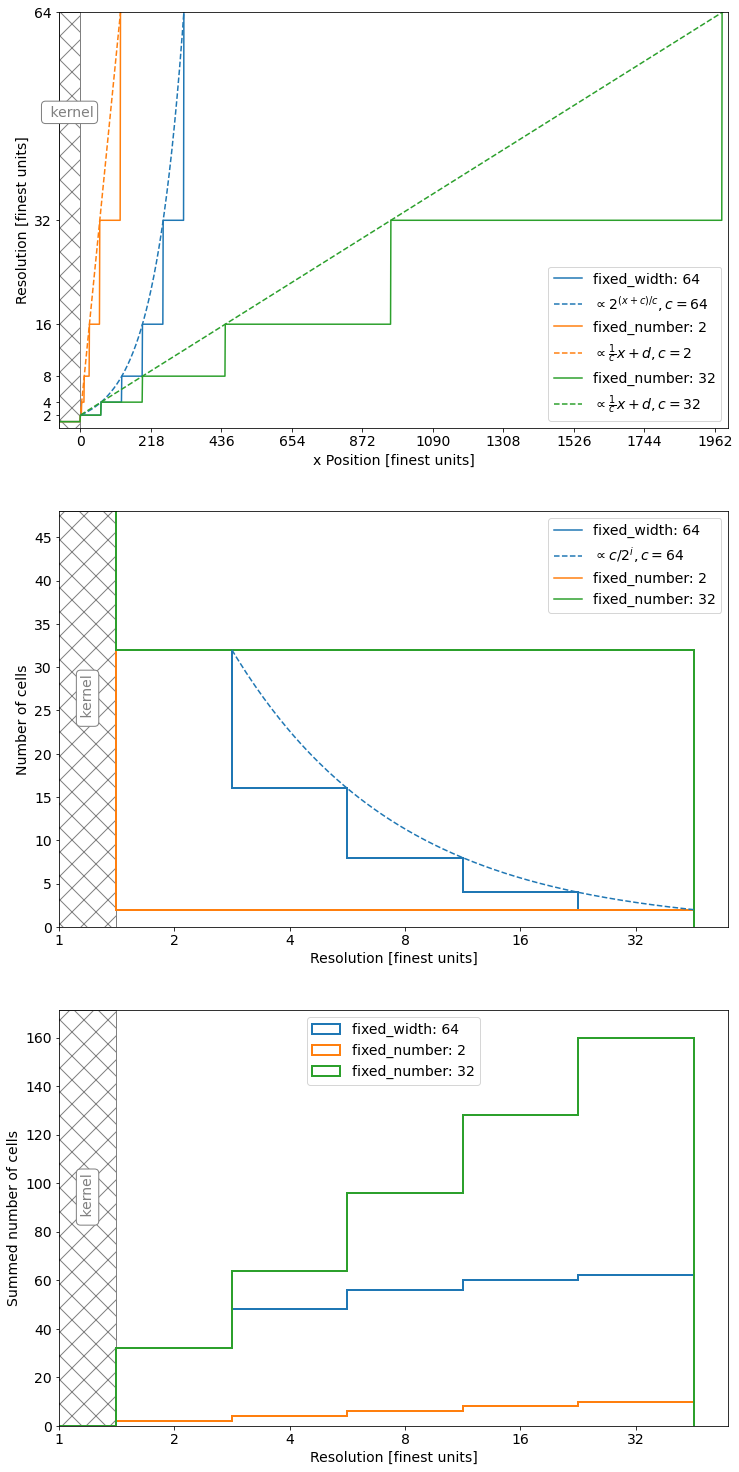

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,26))

for l in [fw_lattice, fn_lattice_narrow, fn_lattice_wide]:
    # plot data from lattice arrays
    l.generate_array()
    pl = gpl(l.array)[0]
    # shorthands
    bins=[2**(x+0.5) for x in range(l.coarse_steps.value)]
    bins.insert(0, 2**(-0.5))
    buffer_size = l.buffer.value * 2**l.coarse_steps.value
    # save a list of artists in .plot
    l.plot = ax1.plot(pl[:buffer_size-2:-1],
             label=f"{l.scheme.name}: {l.borders_width.value}")
    ax1.set_xlim(right=len(pl) - buffer_size*0.9)
    ax2.hist(pl, bins=bins, histtype="step", weights=1/pl,
             lw=2, label=f"{l.scheme.name}: {l.borders_width.value}")
    ax3.hist(pl, bins=bins, histtype="step",
             weights=1/pl, cumulative=1, bottom=-1*np.unique(pl, return_counts=True)[1][0],
             lw=2, label=f"{l.scheme.name}: {l.borders_width.value}")

    
## plot of res over x

# shorthands
coarse_steps = fw_lattice.coarse_steps.value
kernel = np.unique(gpl(fw_lattice.array)[0], return_counts=True)[1][0]
max_x = len(gpl(fn_lattice_wide.array)[0])
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# curves
# power law for fixed_width
fw_curve = np.ma.masked_less_equal(
    np.float_power(
        2, (np.arange(0, len(gpl(fw_lattice.array)[0]))
            -kernel + fw_lattice.borders_width.value
           ) / fw_lattice.borders_width.value
    ), 2)
fw_curve_plot = ax1.plot(fw_curve, c=default_colors[0], ls="--",
         label=f"$\propto2^{{(x + c)/c}}, c=${fw_lattice.borders_width.value}")
# linear for fixed_number
fn_narrow_curve = np.ma.masked_less_equal(
    (np.arange(0, len(gpl(fn_lattice_narrow.array)[0]))
        / fn_lattice_narrow.borders_width.value
        + 2 - kernel / fn_lattice_narrow.borders_width.value
    ), 2)
fn_narrow_curve_plot = ax1.plot(fn_narrow_curve, c=default_colors[1], ls="--",
        label=f"$\propto \\frac{{1}}{{c}}x +d, c=${fn_lattice_narrow.borders_width.value}")
fn_wide_curve = np.ma.masked_less_equal(
    (np.arange(0, len(gpl(fn_lattice_wide.array)[0]))
        / fn_lattice_wide.borders_width.value
        + 2 - kernel / fn_lattice_wide.borders_width.value
    ), 2)
fn_wide_curve_plot = ax1.plot(fn_wide_curve, c=default_colors[2], ls="--",
        label=f"$\propto \\frac{{1}}{{c}}x +d, c=${fn_lattice_wide.borders_width.value}")

# layout
ax1_artists = [ fw_lattice.plot[0], fw_curve_plot[0],
                fn_lattice_narrow.plot[0], fn_narrow_curve_plot[0],
                fn_lattice_wide.plot[0], fn_wide_curve_plot[0] ]
res_ticks = [2**x for x in range(coarse_steps+1)]
reg_box = {"ec": "gray", "fc": "w", "boxstyle": "Round"}
# custom legend order
ax1.legend(ax1_artists, [a.get_label() for a in ax1_artists], loc="lower right")
ax1.set_yticks(res_ticks[1:])
ax1.set_ylim(0, res_ticks[-1])
ax1.set_ylabel("Resolution [finest units]")
ax1.set_xlabel("x Position [finest units]")
ax1.xaxis.set_major_locator(ticker.FixedLocator(range(kernel, max_x), 10))
ax1.set_xticklabels(range(0, max_x-kernel))
ax1.set_xlim(left=0)
ax1.axvspan(0, kernel, fill=False, hatch="x", color="gray")
ax1.text(kernel/2, 2**coarse_steps*3/4, s=" kernel", ha="center", color="gray",
    bbox=reg_box, backgroundcolor="w",
)


## histogram of res

# curve for fixed width
xvals = np.linspace(2**1.5, 2**(fw_lattice.coarse_steps.value-0.5), num=500)
fw_dist = fw_lattice.borders_width.value * np.sqrt(2) / xvals
fw_dist_plot = ax2.plot(xvals, fw_dist, c=default_colors[0], ls="--",
                       label=f"$\propto c/2^i, c={fw_lattice.borders_width.value}$")

# reuse artists from ax1, have same color and style
ax2_artists = [fw_lattice.plot[0], fw_dist_plot[0],
               fn_lattice_narrow.plot[0],
               fn_lattice_wide.plot[0]]
# custom legend order
ax2.legend(ax2_artists, [a.get_label() for a in ax2_artists], loc="upper right")
ax2.set_xscale("log", base=2)
ax2.set_xlim(left=1)
ax2.set_xticks(res_ticks[:-1])
ax2.set_xticklabels(f"{l:.0f}" for l in ax2.get_xticks())
ax2.set_xlabel("Resolution [finest units]")
ax2.set_ylim(top=3/4*2**(fw_lattice.coarse_steps.value))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.set_ylabel("Number of cells")
ax2.axvspan(0, 2**0.5, fill=False, hatch="x", color="gray")
ax2.text(2**0.25, ax2.get_ylim()[1]/2, s=" kernel", ha="center", color="gray",
    bbox=reg_box, backgroundcolor="w", rotation="90"
)


## cumulative sum of cells for res

ax3.legend(loc="upper center")
ax3.set_xscale("log", base=2)
ax3.set_xlim(left=1)
ax3.set_xticks(res_ticks[:-1])
ax3.set_xticklabels(f"{l:.0f}" for l in ax3.get_xticks())
ax3.set_xlabel("Resolution [finest units]")
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Summed number of cells")
ax3.axvspan(0, 2**0.5, fill=False, hatch="x", color="gray")
ax3.text(2**0.25, ax3.get_ylim()[1]/2, s=" kernel", ha="center", color="gray",
    bbox=reg_box, backgroundcolor="w", rotation="90"
)

plt.show();

### 1.Plot: Resolution over x

This plot shows how the resolution of the lattice changes with physical (spatial) x. The x-scale is normalized to 0 where the coarsening regions start. We now want to derive the functional forms for curves that give the resolution of the next region when evaluated at the borders and that are plotted with their respective colors as dashed lines.  
From the plot it is obvious that the Ipp scheme follows a linear law. The x points we want to evaluate the functions at are given by
$$
x(i) = \sum_{j=0}^{i-1} c\cdot 2^j,
$$
where $c$ shall be the width parameter for the scheme. In this case it is the fixed number of cells. With $i = 1,2,\ldots$ we number the borders. The resolutions $y(i)$ follow a power law
$$
y(i) = 2^i,
$$
as previously stated. In order to calculate the slope for a linear ansatz we calculate the finite difference $\frac{\Delta y}{\Delta x}$ for the $i$th border
\begin{align}
\Delta x &= x(i+1) - x(i) = \sum_{j=0}^{i} c\cdot 2^j - \sum_{j=0}^{i-1} c\cdot 2^j = c\cdot 2^i, \\
\Delta y &= y(i+1) - y(i) = 2^{i+1} -s^{i}, \\
\frac{\Delta y}{\Delta x} &= \frac{2^{i+1} -s^{i}}{c\cdot 2^i} = \frac{1}{c}.
\end{align}
With this our linear model becomes
$$
y(x_i) = \frac{1}{c} x_i +d.
$$
By adding the index $i$ we want to hint, that this function is only "defined" at the $x_i$ values for each border. The constant $d$ accounts for the shift of kernel. For both lattices with the Ipp scheme such a linear function is included as a dashed line in the plot.

The obvious non-linear function for the Kayran scheme can be obtained as follows. We start again with the x points and corresponding resolutions
\begin{align}
x(i) &= (i-1)\cdot c, \\
y(i) &= 2^i.
\end{align}
$c$ now represents the width of each region. This time we can directly solve for $y(x)$
$$
y(x_i) = 2^{(x_i+c)/c},
$$
which yields a simple power law. Again, a curve following this function is plotted as a blue dashed line.

We can see, that the blue curve starts like the green curve with a small slope and quickly approaches the steep slope of the orange line. The last shown x value represents the end of the coarsening regions. This suggests to us, that with the Kayran scheme we can have the same number of cells for the finer resolved regions as fn_wide, but still keep the coarsening region relatively narrow and approach the regions with coarser resolution fast.

### 2. & 3. Plot: Number of cells

We first look at the number of cells per coarsening region. Here the interpolating behavior of the Kayran scheme becomes obvious. Remember, that we tuned the configuration parameters such that the blue and green lines overlap for the region with resolution 2 and the blue and orange lines overlap for $2^5$.  
The blue curve follows a $c/2^i$ law. For the last borders region it reaches the smallest possible value of 2.

The last plot is the cumulative distribution of the previous plot. It is closely related to the memory requirement when saving values for each lattice cell. Without repeating previous statements, we want to emphasize, that Kayran scheme keeps the total number of cells relatively low and has more cells for the finer resolved regions.

## Discussion

Once again, we want to note that it is not possible to extrapolate the blue curves for lattices with more borders. By changing the borders, we also change the minimal possible width and so the starting points of the curves.

What we do see, however, is that the Kayran scheme provides a ratio between the total number of cells and the number of cells per region that favors finer resolved regions. This allows for more finer cells next to the kernel where we want the highest resolution possible. At this time we can only speculate what the impact of this will be on numerical simulations on these kinds of lattices. The smaller resolution gradient next to the kernel could impact the errors introduced by the borders and coarser resolution positively.